In [1]:
import os
import numpy as np
import scipy
import itk
import sys
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib notebook
from mpl_toolkits import mplot3d
import cv2
import skimage
import skimage.io
from nd2reader import ND2Reader
import pims
from skimage.filters import gaussian

# Part 1: Processing RFP nucleus stained volume

## Read in file

In [2]:
# using nd2reader package
images = ND2Reader('./40x W2 L3-4 good.nd2')
print(images.metadata)

{'total_images_per_channel': 31, 'channels': ['C0NF-405', 'CONF-488', 'CONF-561', 'CONF-640'], 'pixel_microns': 0.17056709276229, 'width': 2048, 'height': 2048, 'date': datetime.datetime(2018, 3, 6, 17, 59, 41), 'experiment': {'description': 'ND Acquisition', 'loops': [{'duration': 0, 'start': 0, 'stimulation': False, 'sampling_interval': 0.0}]}, 'fields_of_view': [0], 'z_levels': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'num_frames': 1, 'frames': [0]}


In [3]:
# convert data to numpy array
np_data = np.empty([31, 2048, 2048])
for i in range(31):
    np_data[i,:,:] = images[i]

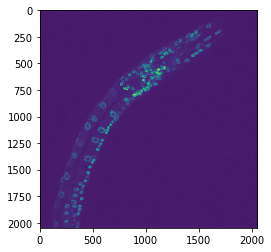

In [8]:
# show example slice raw data
%matplotlib inline
plt.figure()
plt.imshow(np_data[15])

In [9]:
# normalize data to have max value of 1 for displaying purpose
im = np_data/np_data.max()

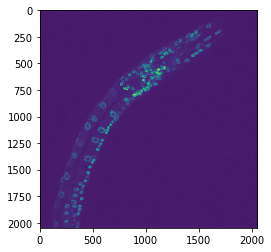

In [10]:
plt.figure()
plt.imshow(im[15])

## Gaussian filtering and subsampling

In [11]:
# Low pass filtering
im_f = gaussian(im, sigma=2)

In [12]:
# im_f_copy = im_f

In [13]:
# im_f_copy[im_f < 0.15] = 0

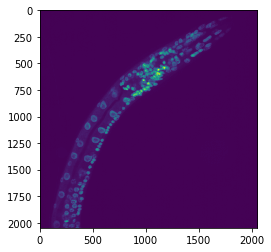

In [15]:
plt.figure()
plt.imshow(im_f[15])

In [16]:
from skimage.transform import rescale, resize, downscale_local_mean

In [17]:
im_resized = image_resized = skimage.transform.resize(im_f, (31, im_f.shape[1] / 4, im_f.shape[2] / 4))

In [152]:
im_mip = np.max(im_f, axis=0)

<IPython.core.display.Javascript object>


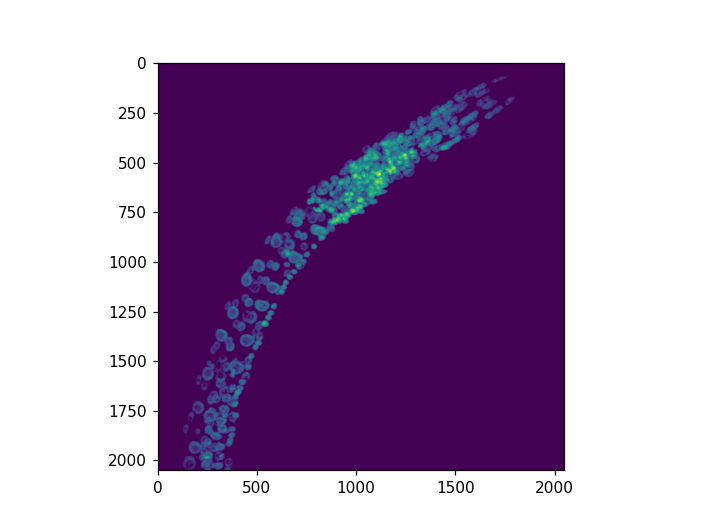

In [153]:
plt.figure()
imgplot = plt.imshow(im_mip)

## Segmentation

### Segmentation using sobel+watershed

In [265]:
from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import slic, join_segmentations
from skimage.morphology import watershed
from skimage.color import label2rgb
from skimage import data

In [266]:
im_copy = np.copy(im_resized)
edges = np.zeros_like(im_copy)

In [267]:
for i in range(31):
    edges[i] = sobel(im_copy[i])

In [268]:
markers = np.zeros_like(im_copy)

In [269]:
foreground, background = 1, 2

In [280]:
markers[im_copy < 0.15] = background
markers[im_copy > 0.35] = foreground

In [281]:
im_copy.min()

0.077543776730400332

In [282]:
ws = skimage.morphology.watershed(edges, markers)

In [283]:
seg1 = skimage.measure.label(ws == foreground)

In [284]:
seg1=seg1.astype(np.uint32)

In [285]:
import neuroglancer
import h5py
import numpy as np
import sys

neuroglancer.set_server_bind_address(bind_port=9991)

viewer=neuroglancer.Viewer()
voxel_size=[1, 1, 5]  # resolution

with viewer.txn() as s:
    s.voxel_size=voxel_size
    s.layers.append(
       name='im1',
       layer=neuroglancer.LocalVolume(
           data=im_resized,
           voxel_size=voxel_size,
       ))
    s.layers.append(
        name='seg',
        layer=neuroglancer.SegmentationLayer(
            source=neuroglancer.LocalVolume(
                data=seg1,
                voxel_size=voxel_size,
            ),
        ))

print(viewer)

http://127.0.0.1:9991/v/b082b3668c47c62d824ecbf5da00fe0535578b47/


0.602214647956
0.0781693261957


<IPython.core.display.Javascript object>


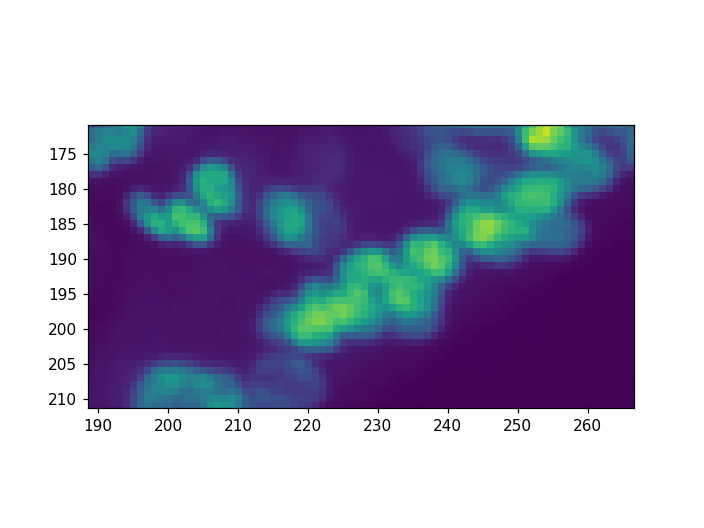

In [335]:
test = im_copy[15]
print(test.max())
print(test.min())
plt.figure()
plt.imshow(test)

In [334]:
skimage.feature.blob_dog(test, min_sigma=1, max_sigma=50, sigma_ratio=1.6, threshold=2.0, overlap=0.5)

array([], shape=(0, 3), dtype=float64)

In [315]:
blob.max()

ValueError: zero-size array to reduction operation maximum which has no identity

### Segmentation using SLIC superpixel

In [222]:
seg2 = slic(im_copy, n_segments=2000, max_iter=10, sigma=1, compactness=0.01,
            multichannel=False)

<IPython.core.display.Javascript object>


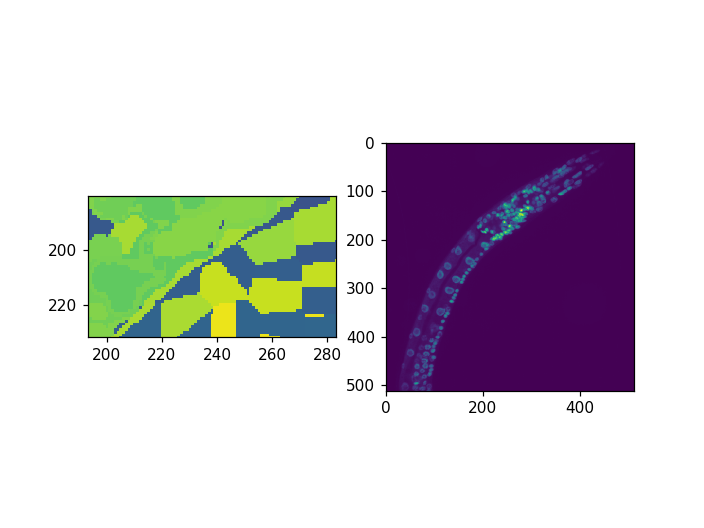

In [223]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(seg2[15])
plt.subplot(1,2,2)
plt.imshow(im_resized[15])

In [155]:
from skimage.feature import peak_local_max
from scipy import ndimage

In [156]:
cd = peak_local_max(im_f, min_distance=5)

In [157]:
mask = np.zeros_like(im_f)

In [158]:
for i in range(len(cd)):
    mask[tuple(cd[i])] = i 

In [159]:
from skimage.morphology import ball
from skimage.morphology import binary_dilation
struct = ball(5)
mask_d = binary_dilation(mask, struct)

In [187]:
mask = mask_d.astype(np.double)
segmentation, _ = ndimage.label(mask)
seg = segmentation.astype(np.double)

<IPython.core.display.Javascript object>


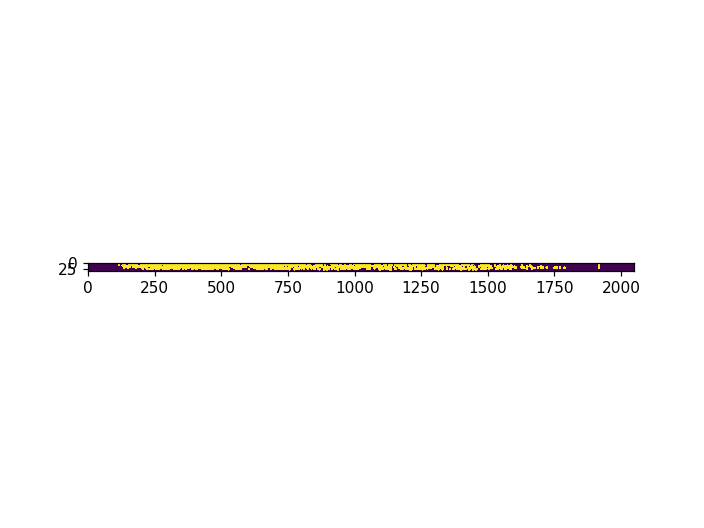

In [160]:
im_mip = np.max(mask_d, axis=1)
plt.figure()
imgplot = plt.imshow(im_mip)

## Display results

In [262]:
import neuroglancer
import h5py
import numpy as np
import sys



neuroglancer.set_server_bind_address(bind_port=9991)

viewer=neuroglancer.Viewer()
voxel_size=[1, 1, 5]  # resolution

class SkeletonSource(neuroglancer.skeleton.SkeletonSource):
    def __init__(self):
        super(SkeletonSource, self).__init__()
        self.vertex_attributes['affinity'] = neuroglancer.skeleton.VertexAttributeInfo(
            data_type=np.float32,
            num_components=1,
        )
        self.vertex_attributes['affinity2'] = neuroglancer.skeleton.VertexAttributeInfo(
            data_type=np.float32,
            num_components=1,
        )

    def get_skeleton(self, i):
        pos = np.unravel_index(i, shape, order='C')[::-1]
        vertex_positions = [pos * voxel_size, pos * voxel_size + np.random.randn(3) * 300]
        edges = [0, 1]
        return neuroglancer.skeleton.Skeleton(
            vertex_positions=vertex_positions,
            edges=edges,
            vertex_attributes=dict(affinity=np.random.rand(2), affinity2=np.random.rand(2)))


with viewer.txn() as s:
    s.voxel_size=voxel_size
    s.layers.append(
       name='im1',
       layer=neuroglancer.LocalVolume(
           data=im_resized,
           voxel_size=voxel_size,
       ))
    s.layers.append(
        name='seg',
        layer=neuroglancer.SegmentationLayer(
            source=neuroglancer.LocalVolume(
                data=seg1,
                voxel_size=voxel_size,
#                 skeletons=SkeletonSource(),
            ),
#             skeleton_shader='void main() { emitRGB(colormapJet(affinity)); }',
#             selected_alpha=0,
#             not_selected_alpha=0,
        ))

print(viewer)

http://127.0.0.1:9991/v/4e94a4323926afeddbfe3451c30155bc1570710a/


In [ ]:
neuroglancer.SegmentationLayer(
        source='precomputed://gs://neuroglancer-public-data/flyem_fib-25/ground_truth',

# Part 2: Segment volumetric GCaMP images

In [3]:
file_list = sorted(os.listdir('./data'))
file_list = [file for file in file_list if file[0]!= '.']